# Deep GP supervised learning

This notebook depends on [GPy](https://github.com/SheffieldML/GPy) and [PyDeepGP](https://github.com/SheffieldML/PyDeepGP). These libraries can be installed via pip:
```
pip install GPy
pip install git+https://github.com/SheffieldML/PyDeepGP.git
```

In [1]:
import deepgp
import GPy
import numpy as np
%matplotlib inline
from pylab import *

In [11]:
# Visualization Utility Functions
def ax_default(fignum, ax):
    if ax is None:
        fig = figure(fignum)
        ax = fig.add_subplot(111)
    else:
        fig = ax.figure
    return fig, ax

def meanplot(x, mu, color='#3300FF', ax=None, fignum=None, linewidth=2,**kw):
    _, axes = ax_default(fignum, ax)
    return axes.plot(x,mu,color=color,linewidth=linewidth,**kw)

def gpplot(x, mu, lower, upper, edgecol='#3300FF', fillcol='#33CCFF', ax=None, fignum=None, **kwargs):
    _, axes = ax_default(fignum, ax)

    mu = mu.flatten()
    x = x.flatten()
    lower = lower.flatten()
    upper = upper.flatten()

    plots = []

    #here's the mean
    plots.append(meanplot(x, mu, edgecol, axes))

    #here's the box
    kwargs['linewidth']=0.5
    if not 'alpha' in kwargs.keys():
        kwargs['alpha'] = 0.3
    plots.append(axes.fill(np.hstack((x,x[::-1])),np.hstack((upper,lower[::-1])),color=fillcol,**kwargs))

    #this is the edge:
    plots.append(meanplot(x, upper,color=edgecol,linewidth=0.2,ax=axes))
    plots.append(meanplot(x, lower,color=edgecol,linewidth=0.2,ax=axes))

    return plots

In [2]:
data = GPy.util.datasets.olympic_marathon_men()
x = data['X']
y = data['Y']

In [24]:
m = deepgp.DeepGP([y.shape[1],5,x.shape[1]],Y=y, X=x, inits=['PCA','PCA'], 
                  kernels=[GPy.kern.RBF(5,ARD=True),GPy.kern.RBF(x.shape[1],ARD=True)], # the kernels for each layer
                  num_inducing=50, back_constraint=False)
m.obslayer.likelihood.variance[:] = y.var()*0.01
for layer in m.layers:
    layer.kern.variance.fix(warning=False)
    layer.likelihood.variance.fix(warning=False)
print(m)


Name : deepgp
Objective : 799.9468614874332
Number of Parameters : 680
Number of Optimization Parameters : 676
Updates : True
Parameters:
  deepgp.                           |             value  |  constraints  |  priors
  obslayer.inducing_inputs          |           (50, 5)  |               |        
  obslayer.rbf.variance             |               1.0  |   +ve fixed   |        
  obslayer.rbf.lengthscale          |              (5,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |  0.00285998869872  |   +ve fixed   |        
  obslayer.Kuu_var                  |             (50,)  |      +ve      |        
  obslayer.latent_space.mean        |           (27, 5)  |               |        
  obslayer.latent_space.variance    |           (27, 5)  |      +ve      |        
  layer_1.inducing_inputs           |           (50, 1)  |               |        
  layer_1.rbf.variance              |               1.0  |   +ve fixed   |        
  layer_1.rbf.lengthscale      

In [25]:
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.kern.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=100)
for layer in m.layers:
    layer.likelihood.variance.constrain_positive(warning=False)
m.optimize(messages=1,max_iters=10000)

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s12  003   4.235306e+02   4.749413e+03 
    00s19  006   3.291568e+02   2.244141e+04 
    01s32  102   5.064110e+01   1.839160e+01 
Runtime:     01s32
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i     f              |g|        
    00s16  007   4.596523e+01   3.343570e+01 
    00s19  008   4.552505e+01   1.760747e+01 
    01s57  102   3.332689e+01   1.118988e+02 
Runtime:     01s57
Optimization status: Maximum number of f evaluations reached

Running L-BFGS-B (Scipy implementation) Code:
  runtime   i       f              |g|        
    00s01  00000   3.332689e+01   1.118988e+02 
    00s07  00003   3.325153e+01   5.843045e+01 
    00s19  00008   3.193705e+01   4.101236e+02 
    02s21  00187   2.109787e+01   5.958302e+00 
    08s24  00776   1.839448e+01   2.162329e+00 
    23s32  02208   1.780019e+01   3.418300e-01 

In [29]:
print(m)


Name : deepgp
Objective : 17.421203356206945
Number of Parameters : 680
Number of Optimization Parameters : 680
Updates : True
Parameters:
  deepgp.                           |              value  |  constraints  |  priors
  obslayer.inducing_inputs          |            (50, 5)  |               |        
  obslayer.rbf.variance             |      25.4476519269  |      +ve      |        
  obslayer.rbf.lengthscale          |               (5,)  |      +ve      |        
  obslayer.Gaussian_noise.variance  |   0.00422398778185  |      +ve      |        
  obslayer.Kuu_var                  |              (50,)  |      +ve      |        
  obslayer.latent_space.mean        |            (27, 5)  |               |        
  obslayer.latent_space.variance    |            (27, 5)  |      +ve      |        
  layer_1.inducing_inputs           |            (50, 1)  |               |        
  layer_1.rbf.variance              |  0.000985791887784  |      +ve      |        
  layer_1.rbf.length

In [36]:
m.obslayer.kern.lengthscale

index,deepgp.obslayer.rbf.lengthscale,constraints,priors
[0],0.29867712,+ve,
[1],41.37649454,+ve,
[2],41.26505521,+ve,
[3],41.23395843,+ve,
[4],41.20768848,+ve,


### Plot the prediction

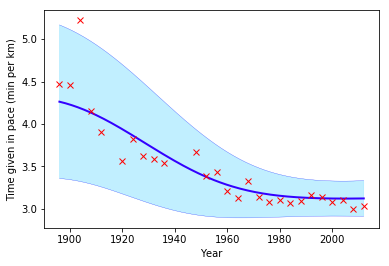

In [51]:
xt = np.linspace(x.min(),x.max(),200)[:,None]
yt = m.predict(xt)
gpplot(xt,yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]))
plot(x,y,'rx')
xlabel('Year')
_=ylabel('Time given in pace (min per km)')

### Fitted GP for each layer

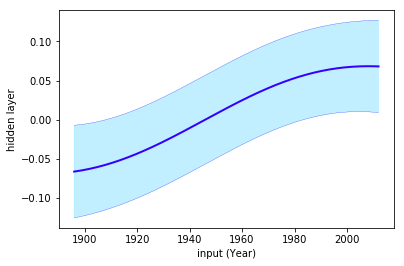

In [53]:
xt = np.linspace(x.min(),x.max(),200)[:,None]
yt = m.layer_1.predict(xt)
gpplot(xt,yt[0][:,0],yt[0][:,0:1]-2*np.sqrt(yt[1]),yt[0][:,0:1]+2*np.sqrt(yt[1]))
xlabel('input (Year)')
_=ylabel('hidden layer')

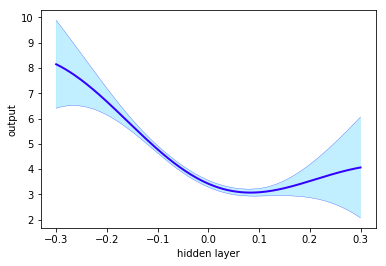

In [63]:
xt = np.zeros((200,5))
xt[:,0] = np.linspace(-0.3,0.3,200)
yt = m.obslayer.predict(xt)
gpplot(xt[:,0],yt[0],yt[0]-2*np.sqrt(yt[1]),yt[0]+2*np.sqrt(yt[1]))
xlabel('hidden layer')
_=ylabel('output')